# Spectral Botany proof of concept

By Tim Hackwood

This Notebook demonstrates techniques for creating spectral species over the Brigalow Belt bioregion in Queensland, Australia and how they may be used to model the distribution of plant species with multispectral remote sensing data.

Methodology for raster segmentation and clustering adapted from Peter Scarth (2022) https://github.com/petescarth/segmentation-example, with pyshepseg https://github.com/ubarsc/pyshepseg leveraged to segment the large dataset.

In [4]:
# Imports
from rios import applier, cuiprogress
import pickle
import geopandas as gpd
from tqdm import tqdm
from shapely import box
import rasterio
from rasterio.plot import reshape_as_image
import numpy as np
import os
import galah
from osgeo import gdal, ogr, gdalconst, osr
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import joblib
from rios import rat
from rios import applier, cuiprogress
from rios import ratapplier
from pyshepseg import tiling
from pyshepseg import tilingstats
from pyshepseg import utils
from pystac_client import Client
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import folium
# from skimage import exposure
import shapely.geometry
import branca
import glob

# Set the working directory to SpectralBotany
os.chdir("/home/tim/rubella/scripts/SpectralBotany")

# Config for Atlas Living Australia APO
galah.galah_config(email = "timothy.hackwood@gmail.com", atlas = "Australia")

AOI = "data/SpectralBotanyTest.gpkg"
Layer = "BrigalowBeltAOI"

# FIles for PCA and Segment outputs
RASTER_PC = "data/Sentinel/Sentinel_brigalow_PCA_segs_id.tif"
RASTER_SEG = RASTER_PC.replace(".tif", "_segs.kea")

<Axes: >

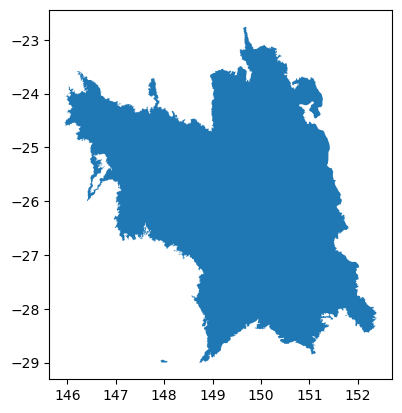

In [2]:
# Load AOI
brigalow = gpd.read_file(AOI, layer=Layer)
# Reproject to WGS84 for STAC API
brigalow.to_crs(4326, inplace=True)
# Plot to check everything looks ok
brigalow.plot()

In [7]:
vrt_files = glob.glob("/home/tim/dentata/Sentinel2_seasonal/*.vrt")

print(gdal.Info(vrt_files[0]))

Driver: VRT/Virtual Raster
Files: /home/tim/dentata/Sentinel2_seasonal/cvmsre_qld_m202112202202_abma2.vrt
       /vsicurl/https://data.tern.org.au/rs/public/data/sentinel2/surface_reflectance/qld/cvmsre_qld_m202112202202_abma2.tif
Size is 160250, 240352
Coordinate System is:
PROJCRS["GDA94_Australian_Albers",
    BASEGEOGCRS["GDA94",
        DATUM["Geocentric Datum of Australia 1994",
            ELLIPSOID["GRS 1980",6378137,298.257222101,
                LENGTHUNIT["metre",1]],
            ID["EPSG",6283]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]],
    CONVERSION["unnamed",
        METHOD["Albers Equal Area",
            ID["EPSG",9822]],
        PARAMETER["Latitude of false origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8821]],
        PARAMETER["Longitude of false origin",132,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8822]],
        PARAME

## Plotting functions

In [28]:
def plot_rgb_to_html(input_tif, output_html, zoom=8, nodata=0, bandorder=[1, 2, 3], show=True):
    """
    Warp tif to wgs84, normalize data and stretch autimatically, and create a folium map with the raster overlay 
    """
    # Virtually warp to wgs84
    PCA_web = input_tif.replace(".tif", "_4326.vrt")
    # Define the target CRS as EPSG:4326 (WGS 84)
    target_crs = 'EPSG:4326'
    # Reproject the raster in memory
    gdal.Warp(PCA_web, input_tif, dstSRS=target_crs, format='VRT')

    # Open the reprojected raster file with rasterio
    with rasterio.open(PCA_web) as src:
        # Read the first three bands
        data = src.read(bandorder).astype(np.float32)
        # Identify the no-data values
        no_data_mask = np.all(data == nodata, axis=0)
        # Normalize data to [0, 1] for each band before applying CLAHE
        data_normalized = np.array([exposure.rescale_intensity(band, in_range=(band.min(), band.max()), out_range=(0, 1)) for band in data])
        # Apply adaptive histogram equalization (CLAHE) for better contrast
        data_equalized = np.array([exposure.equalize_adapthist(band, clip_limit=0.03) for band in data_normalized])
        # Reshape data for plotting
        data = reshape_as_image(data_equalized)
        # Add alpha channel: 0 where no-data, 1 elsewhere
        alpha_channel = np.where(no_data_mask, 0, 1).astype(np.uint8)
        data = np.dstack((data, alpha_channel))
        # Get bounds of the raster
        bounds = src.bounds
        top_left = [bounds.top, bounds.left]
        bottom_right = [bounds.bottom, bounds.right]

    # Create a base map
    m = folium.Map(location=[(top_left[0] + bottom_right[0]) / 2,
                             (top_left[1] + bottom_right[1]) / 2],
                   zoom_start=zoom)

    # Add the raster image as an overlay
    raster_layer = folium.raster_layers.ImageOverlay(
        image=data,
        bounds=[[bottom_right[0], top_left[1]], [top_left[0], bottom_right[1]]],
        opacity=1,
        interactive=True,
        cross_origin=False,
        zindex=1
    )
    raster_layer.add_to(m)

    # Add Layer Control
    folium.LayerControl().add_to(m)

    # Save map to HTML file
    m.save(output_html)
    
    if show:
        return m

In [29]:
def plot_thematic_to_html(input_tif, output_html, zoom=8, nodata=0, cmap='viridis', legend_range=None, show=False):
    """
    Warp tif to wgs84, normalize data and stretch automatically, and create a folium map with the raster overlay.
    """
    # Virtually warp to wgs84
    PCA_web = input_tif.replace(".tif", "_4326.vrt")
    # Define the target CRS as EPSG:4326 (WGS 84)
    target_crs = 'EPSG:4326'
    # Reproject the raster in memory
    gdal.Warp(PCA_web, input_tif, dstSRS=target_crs, format='VRT')

    # Open the reprojected raster file with rasterio
    with rasterio.open(PCA_web) as src:
        # Read the first band
        data = src.read(1).astype(np.float32)
        # Identify the no-data values
        no_data_mask = (data == nodata)
        # Apply quantile stretch only to non no-data values
        valid_data = data[~no_data_mask]
        p2, p98 = np.percentile(valid_data, (2, 98))
        data_stretched = exposure.rescale_intensity(data, in_range=(p2, p98), out_range=(0, 1))
        # Apply adaptive histogram equalization (CLAHE) for better contrast
        data_equalized = exposure.equalize_adapthist(data_stretched, clip_limit=0.03) 
        # Apply colormap
        cmap = plt.get_cmap(cmap)
        data_colored = cmap(data_equalized)
        # Add alpha channel: 0 where no-data, 1 elsewhere
        alpha_channel = np.where(no_data_mask, 0, 1).astype(np.uint8)
        data_colored[..., -1] = alpha_channel
        # Get bounds of the raster
        bounds = src.bounds
        top_left = [bounds.top, bounds.left]
        bottom_right = [bounds.bottom, bounds.right]

    # Create a base map
    m = folium.Map(location=[(top_left[0] + bottom_right[0]) / 2,
                             (top_left[1] + bottom_right[1]) / 2],
                   zoom_start=zoom,
                   )

    # Add the raster image as an overlay
    raster_layer = folium.raster_layers.ImageOverlay(
        image=data_colored,
        bounds=[[bottom_right[0], top_left[1]], [top_left[0], bottom_right[1]]],
        opacity=1,
        interactive=True,
        cross_origin=False,
        zindex=1
    )
    raster_layer.add_to(m)

    # Add Layer Control
    folium.LayerControl().add_to(m)

    # Determine legend range
    legend_min = legend_range[0] if legend_range else p2
    legend_max = legend_range[1] if legend_range else p98

    # Add a legend
    colormap = branca.colormap.LinearColormap(
        colors=[cmap(i) for i in range(cmap.N)],
        vmin=legend_min,
        vmax=legend_max,
        caption='Legend'
    )
    colormap.add_to(m)

    # Save map to HTML file
    m.save(output_html)
    
    if show:
        return m

## Get Landsat data if needed

In [ ]:
# Function to build vrt by band from DEA files on STAC API for each band
def buildVRT(tiles, dir):

    # List of the band names to stack in the VRT
    BandNames = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
    
    vrtList = []

    # Make a full timeseries vrt with each band
    for band in BandNames:
        vrtName = band + '_.vrt'
        vrt = os.path.join(dir, vrtName)
        vrtList.append(vrt)
        urlList = []
        for item in tiles:
            # Get the url for the band
            url = item.assets[band].href
            # Add it to the list
            urlList.append(url.replace(
                's3://',
                '/vsis3/'))
        # Set options for the VRT file
        vrtOptions = gdal.BuildVRTOptions(resampleAlg='nearest',
                                        separate=False,
                                        resolution='highest',
                                        VRTNodata=-999)

        # Then make the VRT file using the list of URLs
        vrtData = gdal.BuildVRT(vrt,
                                urlList,
                                options=vrtOptions)
        
        # Close the VRT file
        vrtData = None

    return vrtList

In [ ]:
# Get landsat-8 data (using DEA barest-earth)
brigalow.to_crs(4326, inplace=True)
bbox = brigalow.total_bounds

# STAC querey
client = Client.open("https://explorer.sandbox.dea.ga.gov.au/stac")
s2Search = client.search(
    bbox=bbox,
    collections=['ls8_barest_earth_albers'],
)
# Show the results of the search
print(f"{s2Search.matched()} items found")

tiles = s2Search.item_collection()

# Build the virtual mosaic for each band
print("Building virtual band mosaics")
vrtList = buildVRT(tiles, 'data/Landsat')

vrtOptions = gdal.BuildVRTOptions(resampleAlg='nearest',
                                separate=True,
                                resolution='highest',
                                VRTNodata=-999)
print("Stacking bands")
vrtData = gdal.BuildVRT('data/Landsat/LandsatBarest_brigalow.vrt',
                        vrtList,
                        options=vrtOptions)

# Close the VRT file
vrtData = None


In [ ]:
# Make a 250m resampled image for this demonstration
Landsat = "data/Landsat/LandsatBarest_brigalow.vrt".replace(".vrt", "_250m.tif")
gdal.Warp(Landsat, "data/Landsat/LandsatBarest_brigalow.vrt", xRes=250, yRes=250, resampleAlg="nearest", format='GTiff')

In [ ]:
# Export landsat to a web map
plot_rgb_to_html(Landsat, "LandsatBarest_brigalow.html", zoom=8, nodata=-999, bandorder=[3, 2, 1])

## Stack with indices and get PCA for segmentation

The 6 Landsat bands are stacked with NDVI and NDWI indices. For future versions, other indicies and timeseries data would be good to add in.

A PCA tiff is produced based on this data stack, then segmented.

In [ ]:
# New version using seasonal Sentinel 2
import glob

# Calculate the bounding box of brigalow (Landsat imagery is in Albers)
brigalow.to_crs(epsg=3577, inplace=True)
bbox = brigalow.total_bounds

s2 = glob.glob("/home/tim/dentata/Sentinel2_seasonal/*2023*.vrt")

datastack = []

for raster in s2:
    with rasterio.open(raster) as src:
        
        # Open a subsampled version of the image
        out_height = int(src.height / 100)
        out_width = int(src.width / 100)

        # Read the subsampled data from src using the bounding box
        img = src.read(window=rasterio.windows.from_bounds(*bbox, transform=src.transform), out_shape=(src.count, out_height, out_width))
        inshape = img.shape
        print(inshape)
        ndvi = (img[3]-img[2])/(img[3]+img[2]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])
        ndwi = (img[1]-img[5])/(img[1]+img[5]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])
            
        # Stack these ratios with the original data
        stack = np.vstack([img, ndvi, ndwi])
        
        datastack.append(stack)
        
datastack = np.array(datastack)

print(datastack.shape)

# Calculate the mean and std across all images (axis 0) for each band
mean_bands = np.mean(datastack, axis=0)
std_bands = np.std(datastack, axis=0)

# Stack the mean and std arrays to form a new data stack
new_datastack = np.concatenate([mean_bands, std_bands], axis=0)


print(new_datastack.shape)

# get mean and std for each band datastack



In [ ]:
# Make a subsampled dataset of multispectral imagery for PCA
with rasterio.open("/home/tim/dentata/Sentinel2_seasonal/cvmsre_qld_m202312202402_abma2.vrt") as src:
    # Calculate the bounding box of brigalow (Landsat imagery is in Albers)
    brigalow.to_crs(epsg=3577, inplace=True)
    bbox = brigalow.total_bounds
    # Open a subsampled version of the image
    out_height = int(src.height / 50)
    out_width = int(src.width / 50)

    # Read the subsampled data from src using the bounding box
    img = src.read(window=rasterio.windows.from_bounds(*bbox, transform=src.transform), out_shape=(src.count, out_height, out_width))
    inshape = img.shape
    print(inshape)
    

In [ ]:
# Get indicies and fit the PCA

N_COMPONENTS = 3 # Change depending on variance.

# Calculate NDVI/NDWI, stack and scale
# Landsat-8 bands - TERN Sentinel 2 seasonal surface reflectance is the same as landsat 8
ndvi = (img[3]-img[2])/(img[3]+img[2]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])
ndwi = (img[1]-img[5])/(img[1]+img[5]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])

    
# Stack these ratios with the original data
stack = np.vstack([img, ndvi, ndwi])
print(stack.shape)

# Reshape stack for scaling
scale = np.reshape(stack, (stack.shape[0], -1))



# Delete unneeded variables
del img
del ndvi
del ndwi

# Rescale with robust scaler    
scaler = RobustScaler()
stack_scale = scaler.fit_transform(scale.T)
# Save the scaler
joblib.dump(scaler, './stack_scaler.pkl')
print(stack_scale.shape)

del scale

# Fit the PCA
pca = PCA(n_components=N_COMPONENTS, svd_solver='full', whiten=True)
pca.fit(stack_scale)
# Print the variance and save the PCA
sumvar = np.cumsum(pca.explained_variance_ratio_)
print(f"Variance explained: {sumvar}")
joblib.dump(pca, './pca.pkl')

# Transform the data to byte scale and save
pcaData = pca.transform(stack_scale).T
byteScale = np.percentile(pcaData,[0.001,99.999],axis=1)
joblib.dump(byteScale, './byteScale.pkl')

In [ ]:
# Apply the PCA to the full image and mask to Brigalow AOI
# Takes ~20 minutes
def _applyPCA(info, inputs, outputs, otherargs):
    """
    Apply PCA to full resolution dataset.
    """
    # Open the images
    s2 = inputs.inlist
    img = s2[0]
    inshape = img.shape
    aoi = inputs.aoi
    nodata = np.any(img == 0, axis=0)

    datastack = []

    for img in s2:

        inshape = img.shape
        ndvi = (img[3]-img[2])/(img[3]+img[2]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])
        ndwi = (img[1]-img[5])/(img[1]+img[5]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])
            
        # Stack these ratios with the original data
        stack = np.vstack([img, ndvi, ndwi])
        
        datastack.append(stack)
            
    datastack = np.array(datastack)

    # Calculate the mean and std across all images (axis 0) for each band
    mean_bands = np.mean(datastack, axis=0)
    std_bands = np.std(datastack, axis=0)
    stdOut = 10000 * 10000 + std_bands
    print(stdOut.shape)
    stdOut[:, np.any(nodata)] = 0
    outputs.ndviSD = stdOut.astype(np.uint16)

    # Stack the mean and std arrays to form a new data stack
    stack = np.concatenate([mean_bands, std_bands], axis=0)

    scaled_stack = np.reshape(stack, (stack.shape[0], -1)).astype('float32').T

    # Apply the PCA    
    pc = otherargs.pca.transform(otherargs.scaler.transform(scaled_stack))
    # Rescale to 16bit
    pc = np.round(np.clip(1.0 + 65534.0
                        * (pc-otherargs.bytescale[0])
                        / (otherargs.bytescale[1]-otherargs.bytescale[0])
                        ,1,65535))
        
    # Reshape the output
    pc = np.reshape(pc.T,(pc.shape[1],inshape[1],inshape[2]))
    # Mask the output for no data

    pc[:,np.any(stack == otherargs.noData,axis=0)] = 0
    pc[:, np.any(aoi == 0, axis=0)] = 0 # mask to the AOI
    outputs.pc =  pc.astype(np.uint16)

# Get the no data value
ds = gdal.Open("/home/tim/dentata/Sentinel2_seasonal/cvmsre_qld_m202109202111_abma2.vrt")
noData = ds.GetRasterBand(1).GetNoDataValue()
    
# Create the RIOS file objects
infiles = applier.FilenameAssociations()
outfiles = applier.FilenameAssociations()

# Setup the IO
infiles.inlist = glob.glob("/home/tim/dentata/Sentinel2_seasonal/*2023*.vrt")
infiles.aoi = "data/SpectralBotanyTest.gpkg"

outfiles.pc = RASTER_PC
outfiles.ndviSD = "./NDVI_SD"

# Get the otherargs
otherargs = applier.OtherInputs()
otherargs.pca = joblib.load("pca.pkl")
otherargs.scaler = joblib.load("stack_scaler.pkl")
otherargs.bytescale = joblib.load("byteScale.pkl")
otherargs.noData = noData

# Controls for the processing   
controls = applier.ApplierControls()
controls.vectorlayer = "BrigalowBeltAOI"
controls.setBurnValue = 1
controls.windowxsize = 512
controls.windowysize = 512
controls.setStatsIgnore(0) #  nodata
controls.progress = cuiprogress.CUIProgressBar()
controls.setFootprintType("INTERSECTION")
controls.setResampleMethod("near")
controls.setOutputDriverName("GTIFF")
controls.setCreationOptions(["COMPRESS=DEFLATE",
                                "ZLEVEL=9",
                                "PREDICTOR=2",
                                "BIGTIFF=YES",
                                "TILED=YES",
                                "INTERLEAVE=BAND",
                                "NUM_THREADS=ALL_CPUS",
                                "BLOCKXSIZE=512",
                                "BLOCKYSIZE=512"])

# Set concurrency depending on system
conc = applier.ConcurrencyStyle(numReadWorkers=3,
                                numComputeWorkers=2,
                                computeWorkerKind="CW_THREADS",
                                readBufferPopTimeout=120,
                                computeBufferPopTimeout=120
                                )

controls.setConcurrencyStyle(conc)

# Run the function
print("Processing PCA")
applier.apply(_applyPCA, infiles, outfiles, otherargs, controls=controls)   

In [ ]:
# Make a 250m resampled image for this demonstration
PCA_250m = RASTER_PC.replace(".tif", "_250m.tif")
gdal.Warp(PCA_250m, RASTER_PC, xRes=250, yRes=250, resampleAlg="nearest", format='GTiff')

In [ ]:
# plot the result to a slippy map
plot_rgb_to_html(PCA_250m, "PCA_250m.html", zoom=8, show=True)


## Segment the PCA to get Spectral Species 

This segmentation method uses a tiled version of Shepard segmentation and is great for larger dataset as the data are chunked into managable sizes before being stitched back together.

Shepard segmentation is based on k-means clustering and seems functionally identical to methods used for spectral species extraction.

In [ ]:
# Get NDVI and NDMI distributions to add into spatial statistics
def indexDist(vrtList):

    ndvistack = []
    ndwistack = []

    for img in vrtList:

        inshape = img.shape
        ndvi = (img[3]-img[2])/(img[3]+img[2]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])
        ndwi = (img[1]-img[5])/(img[1]+img[5]+np.finfo(float).eps).reshape(1, inshape[1], inshape[2])
            
        # Stack these ratios with the original data
        ndvistack.append(ndvi)
        ndwistack.append(ndwi)
            
    ndvistack = np.stack(ndvistack, axis=0)
    ndwistack = np.stack(ndwistack, axis=0)

    # Get new stack with 5th, 25th, 50th, 75th and 95th percentiles
    ndviStats = np.percentile(ndvistack, [5, 25, 50, 75, 95], axis=0)
    ndwiStats = np.percentile(ndwistack, [5, 25, 50, 75, 95], axis=0)

    return ndviStats, ndwiStats

        

In [ ]:
SEGMENT_SIZE = 100 # Approximately 1 hectare minimum segment size @ 10m pixels 
N_COMPONENTS = 4 # Number of PCA components


# Segment using the tiled version
print('Segmenting')
tiledSegResult = tiling.doTiledShepherdSegmentation(RASTER_PC, RASTER_SEG,
            minSegmentSize=SEGMENT_SIZE, numClusters=512,
            bandNumbers=None, subsamplePcnt=None,
            maxSpectralDiff='auto', spectDistPcntile=25,
            imgNullVal=0, fourConnected=True, verbose=True,
            simpleTileRecode=False, outputDriver='KEA', kmeansObj=None)
           
# Do histogram, stats and colour table on final output file.
print('Adding Histogram, Stats and Colour Table')
outDs = gdal.Open(RASTER_SEG, gdal.GA_Update)
hist = tiling.calcHistogramTiled(outDs, tiledSegResult.maxSegId, writeToRat=True)
band = outDs.GetRasterBand(1)
utils.estimateStatsFromHisto(band, hist)
utils.writeRandomColourTable(band, tiledSegResult.maxSegId+1)
del outDs

# Add the original Image Stats
print('Adding Image Stats')
for imgbandnum in range(1,N_COMPONENTS+1):
    statsSelection = [
        ('pca_Band_{}_mean'.format(imgbandnum), 'mean'),
        ('pca_Band_{}_std'.format(imgbandnum), 'stddev')]
    tilingstats.calcPerSegmentStatsTiled(RASTER_PC, imgbandnum, RASTER_SEG,statsSelection)

# Export the segmentation as tifs for visualisation
print('Exporting Segmentation')
infiles = applier.FilenameAssociations()
outfiles = applier.FilenameAssociations()   
infiles.image = RASTER_SEG
outfiles.id = RASTER_SEG.replace('.kea', '_id.tif')
outfiles.rgb = RASTER_SEG.replace('.kea', '_rgb.tif')

otherargs = applier.OtherInputs()
# Using a loop to read and store each 0 column into otherargs
for i in range(1, N_COMPONENTS+1):
    setattr(otherargs, f'b{i}', 
            np.round(rat.readColumn(infiles.image, f'pca_Band_{i}_mean')).astype(np.uint16))

otherargs.noData = 0
controls = applier.ApplierControls()
controls.windowxsize = controls.windowysize = 512  # Set both attributes on the same line
controls.setReferenceImage(RASTER_SEG)
controls.setStatsIgnore(0)
controls.setOutputDriverName("GTIFF")
controls.setCreationOptions([
    "COMPRESS=DEFLATE",
    "ZLEVEL=9",
    "BIGTIFF=YES",
    "TILED=YES",
    "INTERLEAVE=BAND",
    "NUM_THREADS=ALL_CPUS",
    "BLOCKXSIZE=512",
    "BLOCKYSIZE=512"
])

def exportColor(info, inputs, outputs, otherargs):   
    data = inputs.image.flatten()
    # Access b1 through b3 from otherargs using a loop instead of individual lines
    rgb = np.vstack([getattr(otherargs, f'b{i}')[data] for i in range(1, N_COMPONENTS+1)])
    outputs.id = data.reshape((1,) + inputs.image.shape[1:]).astype(np.uint32)
    outputs.rgb = rgb.reshape((rgb.shape[0],) + inputs.image.shape[1:]).astype(np.uint16)

applier.apply(exportColor, infiles, outfiles, otherargs, controls=controls)

In [ ]:
# Plot the RGB segmentation to inspect the segments
plot_rgb_to_html(RASTER_SEG.replace('.kea', '_rgb.tif'), "segmentationRGB.html", zoom=8, show=True)

## Cluster the segments based on segment mean and std reflectance

Note: This next step exracts the 'Spectral Species', however for this analysis,
the segments from the previous step will be used instead.

To determine a 'good' number of clusters, the silhouette score for 10-256 clusters will be computed. In practice, something like aglomerative clustering may produce better results.

In [ ]:
# Use K-means to cluster the segments. This would be a categorical predictor for a SDM

wantedAttributes = ['pca_Band_1_mean', 'pca_Band_1_std', 'pca_Band_2_mean', 'pca_Band_2_std', 'pca_Band_3_mean', 'pca_Band_3_std', 'pca_Band_4_mean', 'pca_Band_4_std']

# Read the data into an array
clusterData  = np.transpose([rat.readColumn(RASTER_SEG,name) for name in wantedAttributes])

# Drop the first row, as it contains the nodata
clusterData = clusterData[1:]

# Scale the data
clusterData = RobustScaler().fit_transform(clusterData)

# Sample the data to reduce the number of points
MAX_TESTING_POINTS = 2000000 # In practice, a much larger sample size would be used
sampleSize = min(MAX_TESTING_POINTS,clusterData.shape[0])
sampleIdx = np.random.choice(clusterData.shape[0],sampleSize,replace=False)

maxClusters = 30

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

def minibatch_kmeans_elbow(X, max_clusters=10, batch_size=100):
    # Compute the total inertia (inertia with 1 cluster) for explained variance calculation
    total_inertia = MiniBatchKMeans(n_clusters=1, batch_size=batch_size, random_state=42).fit(X).inertia_

    # List to store the explained variance percentages
    explained_variance_percent = []

    # Loop over the number of clusters
    for k in tqdm(range(1, max_clusters + 1), desc='Finding optimal number of clusters'):
        # Initialize MiniBatchKMeans
        kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, random_state=42)
        
        # Fit the model
        kmeans.fit(X)
        
        # Calculate explained variance percentage
        variance_explained = 1 - (kmeans.inertia_ / total_inertia)
        explained_variance_percent.append(variance_explained * 100)

    # Plot the elbow curve for explained variance
    plt.figure(figsize=(7, 5))
    plt.plot(range(1, max_clusters + 1), explained_variance_percent, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Explained Variance (%)')
    plt.title('Elbow Method using Explained Variance')
    plt.grid(True)
    plt.show()
    
    return explained_variance_percent

# Example usage:
# X is your dataset as a NumPy array or Pandas DataFrame
variance = minibatch_kmeans_elbow(clusterData[sampleIdx], max_clusters=maxClusters)



# # Find the optimal number of clusters
# inertia = []
# silhouette = []
# nclasses = range(10,256)
# for c in tqdm(nclasses, desc='Finding optimal number of clusters'):
#     kmeans = MiniBatchKMeans(n_clusters=c).fit(clusterData[sampleIdx])
#     inertia.append(kmeans.inertia_)
#     silhouette.append(silhouette_score(clusterData[sampleIdx], kmeans.labels_))

# # Find top 5 number of classes and silhouette score
# top5 = np.argsort(silhouette)[::-1][:5]
# print(f"Top 5 number of classes: {np.array(nclasses)[top5]}")

# # Plot the silhouette score
# plt.figure(figsize=(12,4))
# plt.plot(nclasses, silhouette)
# plt.grid()
# plt.title('Clustering silhouette score')
# plt.xlabel('Number of clusters')

In [6]:
# Cluster the data using K-means and write to a csv with other Segment columns
OPTIMAL_NUM_CLUSTERS = 30
# Cluster the full dataset
kmeans = MiniBatchKMeans(n_clusters = OPTIMAL_NUM_CLUSTERS).fit(clusterData)
# Get the cluster labels and add one to avoid zero values
clusterLabels = kmeans.labels_ + 1
# Add back in the first row of nodata
clusterLabels = np.insert(clusterLabels,0,0)

# Write cluster labels to kea
rat.writeColumn(RASTER_SEG, f'clust{OPTIMAL_NUM_CLUSTERS}', np.insert(kmeans.labels_ + 1, 0, 0))

# Write to .csv
# Get the column names
colNames = rat.getColumnNames(RASTER_SEG)
# Read the data into an array
allData = np.transpose([rat.readColumn(RASTER_SEG, name) for name in colNames])
# Add an index column
allData = np.vstack((np.arange(len(allData)),allData.T)).T
# Add the kmeans labels
allData = np.vstack((allData.T,clusterLabels)).T
# Make a header
colNames.insert(0,'segid')
colNames.append('kmeans_label')
header = ','.join(colNames)
# Write the file
np.savetxt(RASTER_SEG.replace(".kea", ".csv"),allData,fmt='%8.3f',delimiter=',',header=header,comments='')

In [ ]:
#  Depending on data sharing, a new Geopackage could be created with the segmentation polygons

# Append the segmentation to an existing Geopackage
outDs = gdal.Open(RASTER_SEG.replace(".kea", "_id.tif"))
band = outDs.GetRasterBand(1) # Band 1 is the segment ids
# Open the existing vector datasource
vecDs = ogr.Open(AOI, 1)  # 1 means it's opened in update mode
# Create a new layer in the existing geopackage
vecLayer = vecDs.CreateLayer('BrigalowSegID', srs=osr.SpatialReference(wkt=outDs.GetProjection()))
vecLayer.CreateField(ogr.FieldDefn('segid', ogr.OFTInteger))
# Polygonize
vecDs.StartTransaction()
gdal.Polygonize(band, None, vecLayer, 0, [], callback=None)
vecDs.CommitTransaction()

del outDs
del vecDs

In [25]:
# Write the segmentation to a new Geopackage

segDS = RASTER_SEG.replace(".kea", "_segid.gpkg")

outDs = gdal.Open(RASTER_SEG.replace(".kea", "_id.tif"))
band = outDs.GetRasterBand(1)  # Band 1 is the segment ids

# Create a new vector datasource
driver = ogr.GetDriverByName("GPKG")
if os.path.exists(segDS):
    driver.DeleteDataSource(segDS)
vecDs = driver.CreateDataSource(segDS)

# Create a new layer in the new geopackage
vecLayer = vecDs.CreateLayer('BrigalowSegID', srs=osr.SpatialReference(wkt=outDs.GetProjection()))
vecLayer.CreateField(ogr.FieldDefn('segid', ogr.OFTInteger))

# Polygonize
vecDs.StartTransaction()
gdal.Polygonize(band, None, vecLayer, 0, [], callback=None)
vecDs.CommitTransaction()

del outDs
del vecDs

In [8]:
segDS = AOI.replace(".gpkg", "_segs.gpkg")

In [3]:
# Join segments to attributes .csv
Segs = gpd.read_file(segDS, layer='BrigalowSegID')
attributes = gpd.read_file(RASTER_SEG.replace(".kea", ".csv"))


# Join on segid
attributes['segid'] = attributes['segid'].astype(float).astype(int)
attributes['kmeans_label'] = attributes['kmeans_label'].astype(float).astype(int)
Segs = Segs.merge(attributes, on='segid')
Segs.head()


## Get an example species and test Species Distribution Modelling on the Spectral Species

For the proof of concept, I've picked a species of Casuarina, on the assumption that they have distinct reflectivity based on their physiology. This may or may not hold true at 250m pixels, however.

In [7]:
# Get species data from ALA API
# Use the bbox from the AOI to get the occurrences

import galah.atlas_citation


bbox = box(*brigalow.total_bounds)

# Coords need to be in 4283/4326

brigalow_occ = galah.atlas_occurrences(bbox = bbox, 
                                    taxa=['plantae'],
                                    filters=["year>=2014"],
                                    fields=["decimalLatitude",
                                            "decimalLongitude",
                                            "eventDate", 
                                            "scientificName",
                                            "vernacularName",
                                            "coordinateUncertaintyInMeters"],
                                )
# Make a geodataframe from the lat and longs
brigalow_occ = gpd.GeoDataFrame(
    brigalow_occ, 
    geometry=gpd.points_from_xy(brigalow_occ.decimalLongitude, brigalow_occ.decimalLatitude),
    crs="EPSG:4326"
)

brigalow_occ.to_crs(3577, inplace=True)

In [ ]:
brigalow_occ.columns

In [12]:
Segs = gpd.read_file("/home/tim/rubella/scripts/SpectralBotany/data/SpectralBotanyTest_Casuarina_cristata.gpkg")

In [15]:
Segs = Segs.drop(columns=['presence', 'presence_probabilities'])

In [ ]:
Segs

In [16]:
# Make a dataframe with presence data and join to Segment data
# Filter the DataFrame for "Casuarina cristata"
filtered_gdf = brigalow_occ[brigalow_occ['scientificName'].str.contains("Dichanthium sericeum")].copy()

# Replace spaces with underscores in species names
filtered_gdf.loc[:, 'species_name'] = filtered_gdf['scientificName'].str.replace(" ", "_")

# Set presence to 1
filtered_gdf.loc[:, 'presence'] = 1

# Drop unneeded columns
filtered_gdf.drop(columns=['decimalLatitude', 'decimalLongitude', 'eventDate', 'scientificName', 'vernacularName'], inplace=True)

# Intersect with segments
Segs_intersected = gpd.overlay(Segs, filtered_gdf, how='intersection', keep_geom_type=False)

Segs.loc[Segs['segid'].isin(Segs_intersected['segid']), 'presence'] = 1

In [ ]:
# Generate pseudoabsences

Absence_ratio = 5 # Note: I can't remember the research for absence/presence ratios in SDMs, but this will do for testing

Segs_presence = Segs.copy()

Segs_presence = Segs_presence[Segs_presence['segid'] != 0] # Remove the no data segment

# Get number of presences
num_presence = len(Segs_presence[Segs_presence['presence'] == 1])

# Randomly select rows by segid
random_rows = Segs_presence.sample(n=num_presence*Absence_ratio, random_state=42)

# Set these segments to absent '0'
Segs_presence.loc[Segs_presence['segid'].isin(random_rows['segid']), 'presence'] = 0

# Print number of presences and absences in the dataset
num_presence = len(Segs_presence[Segs_presence['presence'] == 1])
num_absence = len(Segs_presence[Segs_presence['presence'] == 0])
print("Number of presences:", num_presence)
print("Number of absences:", num_absence)


In [18]:
# Save to a csv
speciesDS = AOI.replace(".gpkg", "_dichanthium.csv") # Write to a new geopackage to enable upload to git
Segs_presence.to_csv(speciesDS, index=False)

In [ ]:
# Plot the data

# Make points from centroid of polygon
points = Segs_presence.copy()
points['centroid'] = points.centroid
points.set_geometry('centroid', inplace=True)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the presence column with a red/blue colormap
points.plot(column='presence', cmap='bwr', ax=ax, legend=True)

# Set the title and axis labels
ax.set_title('Presence/Absence')

# Show the plot
plt.show()

In [22]:
# Write the points to a geopackage
points['geometry'] = points['centroid']
points.drop(columns=['centroid'], inplace=True)
points.to_file("./data/Dichanthium.geojson", driver='GeoJSON')


## Use Random Forest to estimate Casuarina species distribution

This is a basic test on a Casuarina species as a proof of concept for generating a SDM from spectral species data. Segment mean reflectance and variability (Standard Deviation)
will be used as predictors in a Random Forest model to predict the probability of occurance of Casuarina castata in the Brigalow Belt.

In [23]:
# Make test/train datasets
from sklearn.model_selection import train_test_split

random_state = 42 # Set a random seed for reproducibility

presAbs = Segs_presence.dropna(subset=['presence']) # split data to the training set and the full ds

predictors = ['pca_Band_1_mean', 'pca_Band_1_std', 'pca_Band_2_mean',
              'pca_Band_2_std', 'pca_Band_3_mean', 'pca_Band_3_std'] 

# Get the x and y data with only spectral predictors
x = presAbs[predictors]
y = presAbs['presence']

# Split training set into test and train
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=random_state)

In [ ]:
# Fit a Random Forest model

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


# Creating a pipeline that includes scaling and the random forest classifier
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', RandomForestClassifier(random_state=random_state))
])

# Training the model
pipeline.fit(X_train, y_train)

# Making predictions on the validation set
y_pred = pipeline.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Extracting feature importances
feature_importances = pipeline.named_steps['classifier'].feature_importances_
most_important_feature = predictors[feature_importances.argmax()]
importance_value = feature_importances.max()

# Print pipeline, accuracy, report, most_important_feature, and importance_value
print("Pipeline:", pipeline)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

# Plot predictor importances
plt.figure(figsize=(10, 6))
plt.barh(predictors, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Predictor')
plt.title('Predictor Importances')
plt.show()


In [ ]:
# Make predictions on the full dataset
# Getting probabilities for all classes
probabilities = pipeline.predict_proba(Segs_presence[predictors])

# Get model classes to check order
classes = pipeline.classes_
print("Class order in model:", classes)  # This line will print the order of classes

# Class '1' is 'presence', find its index
presence_index = list(classes).index(1)  # Change 1 to the appropriate class label if different

# extract probabilities for the 'presence' class
Segs_presence['presence_probabilities'] = probabilities[:, presence_index]

# Scale presence probabilities to 0 - 100 and convert to integer
Segs_presence['presence_probabilities'] = (Segs_presence['presence_probabilities'] * 100).astype(int)


In [26]:
# Write to a gpkg
Segs_presence.to_file(speciesDS.replace(".csv", ".gpkg"), layer='Dichanthium', driver='GPKG')

In [27]:
from osgeo import gdal, ogr

# Rasterise the presence probabilities for a better visual

# Create a new raster file
outRaster = RASTER_SEG.replace(".kea", "Dichanthium_prob.tif")

# Open the geopackage
gpkg_ds = ogr.Open(speciesDS.replace(".csv", ".gpkg"))

# Get the layer from the geopackage
layer = gpkg_ds.GetLayerByName("Dichanthium")

# Get the field index of 'presence_probabilities'
field_index = layer.GetLayerDefn().GetFieldIndex("presence_probabilities")

# Define the pixel size (250m)
pixel_size = 250

# Get the extent of the layer
x_min, x_max, y_min, y_max = layer.GetExtent()

# Calculate the number of pixels
x_res = int((x_max - x_min) / pixel_size)
y_res = int((y_max - y_min) / pixel_size)

# Create the output raster
target_ds = gdal.GetDriverByName('GTiff').Create(outRaster, x_res, y_res, 1, gdal.GDT_Byte)
target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))

# Set the projection from the layer
target_ds.SetProjection(layer.GetSpatialRef().ExportToWkt())

# Set NoData value to 255
band = target_ds.GetRasterBand(1)
band.SetNoDataValue(255)

# Rasterize the layer based on the 'presence_probabilities' field
gdal.RasterizeLayer(target_ds, [1], layer, options=["ATTRIBUTE=presence_probabilities"])

# Close the datasets
target_ds = None
gpkg_ds = None

In [ ]:
# get outraster no data
ds = gdal.Open(outRaster)
noData = ds.GetRasterBand(1).GetNoDataValue()

plot_thematic_to_html(outRaster, "Dichathium_prob.html", zoom=8, nodata=noData, legend_range=[0, 100], show=True)